In [23]:
# import base python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [24]:
# import ml framework libraries
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import np_utils

In [32]:
def processData():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    
    # printing first 10 negative images
    for i in range(10):
        
        plt.subplot(3,4,i+1)
        plt.tight_layout()
        plt.imshow(np.subtract(255, x_train[i]), cmap ='gray', interpolation='none')
        plt.title("Neg Digits: {}".format(y_train[i]))
        plt.xticks([])
        plt.yticks([])
        
    # define the train data as float 32
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    
    # normalize here
    x_train /= 255
    x_test /= 255
    
    # do one-hot encoding here for labels using npy
    y_train = np_utils.to_categorical(y_train, 10)
    y_test = np_utils.to_categorical(y_test, 10)

    # step to do before padding
    x_train = x_train.reshape(x_train.shape[0], 28,28,1)
    x_test = x_test.reshape(x_test.shape[0], 28,28,1)
    
    # pad the xtrain and xtest with 2 on both sides (28 + 2 + 2 = 32) 
    x_train = np.pad(x_train, [[0, 0], [2, 2], [2, 2], [0, 0]], mode = 'constant')
    x_test = np.pad(x_test, [[0, 0], [2, 2], [2, 2], [0, 0]],mode = 'constant')
    
    # negtive train with normal train
    x_train_neg_concat = np.concatenate((x_train, np.subtract(255, x_train)), axis = 0) 
    y_train_neg_concat = np.concatenate((y_train, y_train), axis = 0) 
     
    # get variance of the two types of images (not necessary needed?)
    print('x_train variance:', np.var(x_train))
    print('x_train_neg variance:', np.var(x_train_neg_concat))
    
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    print('x_train_neg:', x_train_neg_concat.shape)
    print(x_train_neg_concat.shape[0], 'negative train samples')
    
    return [x_train, x_test, y_train, y_test, x_train_neg_concat, y_train_neg_concat]

In [33]:
# Let's define our network architecure here
def LeNet(filter_size, max_pooling_size, dropout,activation_func, num_classes, optimizer, lr, decay_val):
    
    num_filters_fcl_1 = 120
    num_filters_fcl_2 = 84

    model = Sequential()
    
    # First layer with kernel size as the filter size
    model.add(Conv2D(16, (filter_size, filter_size), activation = activation_func ,padding='same', input_shape=(32, 32,1)))
    model.add(MaxPooling2D((max_pooling_size, max_pooling_size))) # Max pooling of size 2
    model.add(Dropout(dropout)) # Define the dropout of first layer

    # Second Layer with kernel size as the filter size
    model.add(Conv2D(6, (filter_size, filter_size), activation = activation_func, padding='same',input_shape=(14, 14,1)))
    model.add(MaxPooling2D((max_pooling_size, max_pooling_size))) # Max pooling
    model.add(Dropout(dropout))  # Define Dropout of second layer

    # Flatten the CNN output
    model.add(Flatten())
    
    # Then add 3 dense Layers and their activation funtion for the fully connected network
    model.add(Dense(num_filters_fcl_1)) # fileter size of 120
    model.add(Dense(num_filters_fcl_2, activation = activation_func,))

    model.add(Dense(num_filters_fcl_2)) # filter size of 84
    model.add(Dense(num_filters_fcl_2, activation = activation_func,)) 
 
    # For classification, the activation is softmax
    model.add(Dense(num_classes)) # size = 10
    model.add(Dense(num_classes, activation = 'softmax',))

    # Define loss function = cross entropy
    # Compile and fit
    # I will be trying different optimizers here
    # Different Optimizers parameters are: Adadelta, SGD, RMSprop, Adagrad and Adam
   
    
    if optimizer == 'SGD':
        print(optimizer)
        model.compile(loss ='categorical_crossentropy', 
                       optimizer = keras.optimizers.SGD(learning_rate = lr, momentum = 0.9, decay = decay_val),
                       metrics=['accuracy'])
            
    elif optimizer == 'RMSprop':
        print(optimizer)
        model.compile(loss = 'categorical_crossentropy', 
                       optimizer = keras.optimizers.RMSprop(learning_rate = lr,rho=0.9, momentum=0.0, epsilon=1e-07,  decay = decay_val),
                       metrics=['accuracy'])

    elif optimizer == 'Adagrad':
        print(optimizer)
        model.compile(loss = 'categorical_crossentropy', 
                       optimizer=keras.optimizers.Adagrad(learning_rate = lr, initial_accumulator_value=0.1, epsilon=1e-07, decay = decay_val),
                       metrics = ['accuracy'])

    elif optimizer == 'Adadelta':
        
        model.compile(loss = 'categorical_crossentropy', 
                       optimizer = keras.optimizers.Adadelta(learning_rate = lr, rho = 0.95, epsilon = 1e-07, decay = decay_val),
                       metrics=['accuracy'])

    elif optimizer == 'Adam':
        model.compile(loss = 'categorical_crossentropy', 
                       optimizer = keras.optimizers.Adam(learning_rate = lr, beta_1=0.9, beta_2 = 0.999, epsilon=1e-07, decay = decay_val),
                       metrics=['accuracy'])
    print(model.summary)
    return model  
    

In [34]:
# Plot the accuracy curve
def plot(train_value, test_value, acc_val):
    f, ax = plt.subplots()
    plt.plot([None] + train_value, 'o-')
    plt.plot([None] + test_value, 'x-')
    plt.legend(['Train ' + acc_val, 'Test ' + acc_val], loc=0)
    plt.title('Training and Test ' + acc_val + ' per epoch')
    plt.xlabel('Epoch')
    plt.ylabel(acc_val)
    plt.show()

In [35]:
# define the parameters to use
filter_size = 5
max_pooling_size = 2
epochs = 40
batch = 128
num_classes = 10

x_train variance: 0.07574464
x_train_neg variance: 16231.118
x_train shape: (60000, 32, 32, 1)
60000 train samples
10000 test samples
x_train_neg: (120000, 32, 32, 1)
120000 negative train samples


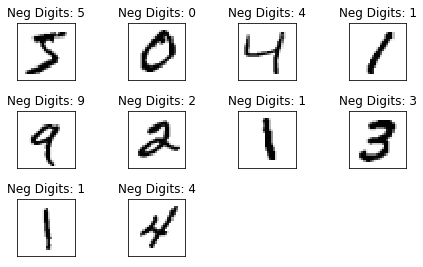

In [36]:
x_train, x_test, y_train, y_test, x_train_neg, y_train_neg = processData()

In [37]:
# define hyperparameters
activation = 'relu'    #['linear', 'selu', 'relu', 'tanh', 'sigmoid']
dropout = 0.25         
optmizer = 'Adam'      #['SGD', 'Adadelta', 'Adam', 'Adagrad', 'RMSprop']
learningRate = 0.001   
decayVal = learningRate / epochs

In [38]:
start_time = time.time()
    
lenetModel = LeNet(  filter_size,
                     max_pooling_size,
                     dropout,
                     activation, 
                     num_classes,
                     optmizer,
                     learningRate,
                     decayVal )

print('Start training.')

hist = lenetModel.fit(x_train, y_train, epochs = epochs, batch_size = batch,
                    validation_data = (x_test, y_test), verbose=1)
print("Training took {0} seconds.".format(time.time() - start_time))


<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fd8fbe597d0>>
Start training.
Epoch 1/40
469/469 [==============================] - 67s 140ms/step - loss: 0.8375 - accuracy: 0.7174 - val_loss: 0.1193 - val_accuracy: 0.9608
Epoch 2/40
469/469 [==============================] - 66s 140ms/step - loss: 0.1554 - accuracy: 0.9513 - val_loss: 0.0670 - val_accuracy: 0.9782
Epoch 3/40
469/469 [==============================] - 66s 140ms/step - loss: 0.1087 - accuracy: 0.9659 - val_loss: 0.0518 - val_accuracy: 0.9832
Epoch 4/40
469/469 [==============================] - 66s 140ms/step - loss: 0.0929 - accuracy: 0.9701 - val_loss: 0.0415 - val_accuracy: 0.9867
Epoch 5/40
469/469 [==============================] - 66s 140ms/step - loss: 0.0817 - accuracy: 0.9745 - val_loss: 0.0390 - val_accuracy: 0.9872
Epoch 6/40
469/469 [==============================] - 65s 140ms/step - loss: 0.0779 - accuracy: 0.9744 - val_loss: 0.0432 - val_accuracy: 0.9867
Ep

In [39]:
## test on the concatenated images
testRes = lenetModel.evaluate(x_test, y_test, verbose = 1)
print("Test loss {:.4f}, accuracy for normal images {:.2f}%".format(testRes[0], testRes[1] * 100))

313/313 [==============================] - 3s 10ms/step - loss: 0.0256 - accuracy: 0.9913
Test loss 0.0256, accuracy for normal images 99.13%


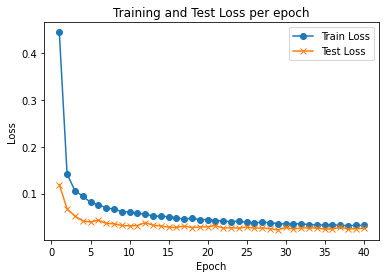

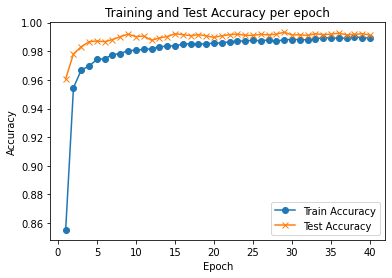

In [40]:
# plot the accuracy vs loss of the trainning images
plot(hist.history['loss'], hist.history['val_loss'], 'Loss')
plot(hist.history['accuracy'], hist.history['val_accuracy'], 'Accuracy')